# ITCS-3156 Final Project
Using Machine Learning models to determine if a room is occupied depending on factors such as temperature, humidity, etc.

In [1]:
from typing import List, Dict, Tuple, Callable, Union
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# small class to hold the data and target of the datasets in one place
class Dataset:
    def __init__(self, data: pd.DataFrame, target: pd.DataFrame):
        self.data = data
        self.target = target

The dataset used here:
Candanedo, Luis. "Occupancy Detection ." UCI Machine Learning Repository, 2016, https://doi.org/10.24432/C5X01N.

In [3]:
# getting the training and testing datasets
room_trn_df = pd.read_csv('datatraining.txt')
room_tst_df = pd.read_csv('datatest.txt')

# features we want to use (columns)
features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

# target column
target = 'Occupancy'

# getting the training data and target
room_trn_data = room_trn_df[features]
room_trn_target = room_trn_df[target]
room_trn = Dataset(room_trn_data, room_trn_target)

# getting the testing data and target
room_tst_data = room_tst_df[features]
room_tst_target = room_tst_df[target]
room_tst = Dataset(room_tst_data, room_tst_target)

In [4]:
pd.concat([room_trn.data, room_trn.target], axis=1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.250000,0.004793,1
2,23.15,27.2675,429.5,714.000000,0.004783,1
3,23.15,27.2450,426.0,713.500000,0.004779,1
4,23.15,27.2000,426.0,708.250000,0.004772,1
5,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...
8139,21.05,36.0975,433.0,787.250000,0.005579,1
8140,21.05,35.9950,433.0,789.500000,0.005563,1
8141,21.10,36.0950,433.0,798.500000,0.005596,1
8142,21.10,36.2600,433.0,820.333333,0.005621,1


In [5]:
pd.concat([room_tst.data, room_tst.target], axis=1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,23.700000,26.272000,585.200000,749.200000,0.004764,1
141,23.718000,26.290000,578.400000,760.400000,0.004773,1
142,23.730000,26.230000,572.666667,769.666667,0.004765,1
143,23.722500,26.125000,493.750000,774.750000,0.004744,1
144,23.754000,26.200000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...
2800,24.290000,25.700000,808.000000,1150.250000,0.004829,1
2801,24.330000,25.736000,809.800000,1129.200000,0.004848,1
2802,24.330000,25.700000,817.000000,1125.800000,0.004841,1
2803,24.356667,25.700000,813.000000,1123.000000,0.004849,1


As we can see, the data contains a few features that may or may not correlate to the target.

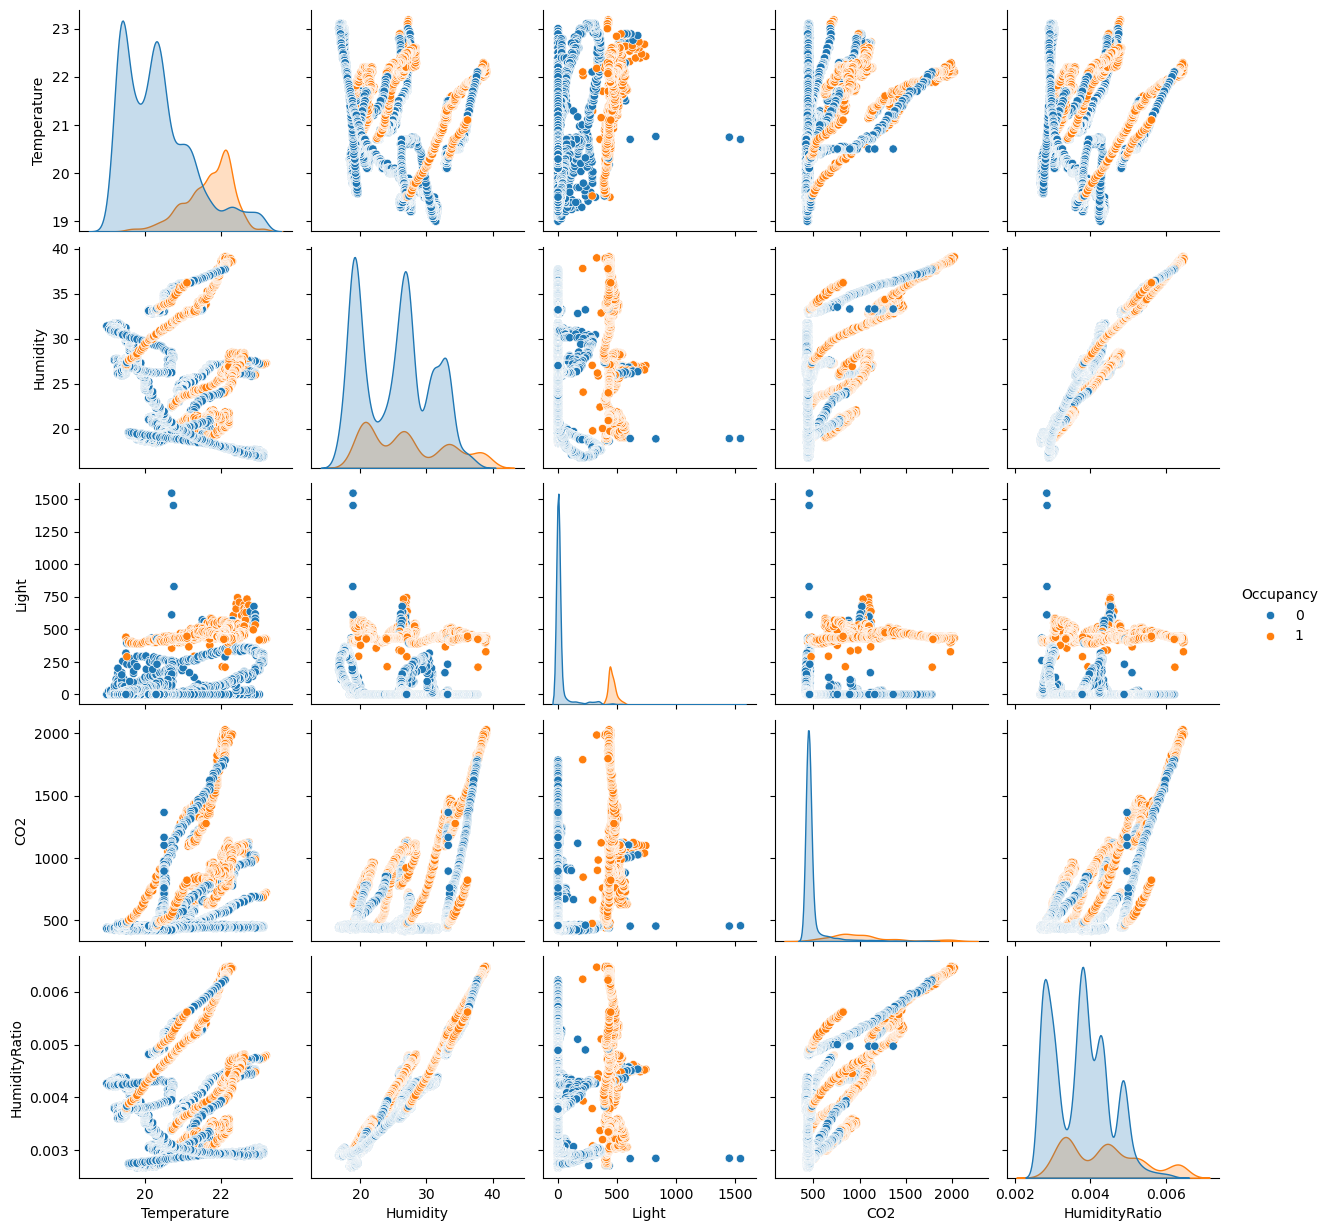

In [6]:
sns.pairplot(pd.concat([room_trn.data, room_trn.target], axis=1), hue='Occupancy')

Seeing this graph, there are a few observations we can make.  
Some of the data seems linearly separable, like the Light and CO2 features. This gives us an idea for one of our models, that being the perceptron. It also greatly helps that the target (occupancy) is already binarized.  
However, some of the features do not correlate with eachother at all. This means dropping those which may give bad results could be beneficial to the prediction. With that in mind, our second model will be the gaussian naive bayes' model.

We use an accuracy function for both models, so we just make it here:

In [7]:
def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
     # reshape to make 1D vector for consistency
    y = y.flatten()
    y_hat = y_hat.flatten()

    # accuracy = (num correct) / (num samples)
    return np.sum(y == y_hat) / len(y)

# The Perceptron Approach

Technically we don't need to binarize the data's classes, however, the features and target are still randomly assorted in the data. It would also be beneficial to set all the features that aren't occupied to -1.

In [8]:
def binarize_classes(
    X: np.ndarray,
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    # copy the data so we dont overwrite the data passed in
    X = X.copy()
    y = y.copy()

    # get the data that is labelled as positive (occupancy == 1)
    pos_labels = np.isin(y, [1])
    X_pos, y_pos = X[pos_labels], np.ones(np.sum(pos_labels))

    # get the data that is labelled as negative (occupancy == 0)
    neg_labels = np.isin(y, [0])
    X_neg, y_neg = X[neg_labels], -np.ones(np.sum(neg_labels))
    
    return np.vstack([X_pos, X_neg]), np.hstack([y_pos, y_neg])

While the data was already preprocessed when we got it, we still need to do a little bit of preprocessing for the data to work in the perceptron. Here's everything we need to do to the data before we use it:
- Binarize the datasets
- Make a validation set
- Standardize the datasets
- Add a bias term

In [9]:
def get_preprocessed_data_perceptron()  -> Tuple[np.ndarray]:
    # binarize both the training set and the testing set
    X_trn, y_trn = binarize_classes(room_trn.data.values, room_trn.target.values)
    X_tst, y_tst = binarize_classes(room_tst.data.values, room_tst.target.values)

    # get the validation set from the training set
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, random_state=42)

    # standardize the features
    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    # add bias term
    X_trn = np.hstack([np.ones((X_trn.shape[0], 1)), X_trn])
    X_vld = np.hstack([np.ones((X_vld.shape[0], 1)), X_vld])
    X_tst = np.hstack([np.ones((X_tst.shape[0], 1)), X_tst])

    # reshape targets to be 2D column vectors
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

Here we implement the perceptron itself. Unfortunately, the model requires an alpha and epochs term, which will be difficult to fine tune later.

In [10]:
class Perceptron():
    def __init__(
        self, 
        alpha: float,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_acc = None
        self.vld_acc = None

    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        # set seed for reproducibility
        np.random.seed(self.seed) 
        self.trn_acc = []
        self.vld_acc = []

        # start the weights off completely randomly
        self.w = np.random.random(X.shape[1])

        # loop through the number of epochs        
        for e in range(self.epochs):
            misclassified = 0

            # loop over the number of samples
            for i in range(X.shape[0]):
                # current data sample
                m = X[i]

                # y_hat = sign(weights @ sample)
                z = self.w.T @ m
                y_hat = np.sign(z)

                # if the predicted value was wrong, change the weights
                if y_hat != y[i]:
                    misclassified += 1

                    self.w += self.alpha * y[i] * m.flatten()

            # this part of the code was written by the instructors of ITCS-3156 and was not written by me
            trn_preds = self.predict(X)
            trn_acc = accuracy(y, trn_preds)
            self.trn_acc.append(trn_acc)
            
            if X_vld is not None and y_vld is not None:
                vld_preds = self.predict(X_vld)
                vld_acc = accuracy(y_vld, vld_preds)
                self.vld_acc.append(vld_acc)

            if misclassified == 0:
                break
        
        return self 
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        # y_hat = sign(X @ weights)
        return np.sign(X @ self.w)

Here we can test our perceptron model.

In [11]:
def perceptron_model(
    alpha: float = 0.1, 
    epochs: int = 100, 
    ignore_graphs: bool = False
):
    # get the preprocessed data for the perceptron
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data_perceptron()

    # fit the training and validation sets
    perceptron = Perceptron(alpha=alpha, seed=42, epochs=epochs)
    perceptron.fit(X_trn, y_trn, X_vld, y_vld)

    # predict based on the testing set
    y_tst_preds = perceptron.predict(X_tst)

    # calculate the accuracy
    accuracy_tst = accuracy(y_tst, y_tst_preds)

    # if we want to make some graphs
    if not ignore_graphs:
        # print the accuracy of the predictions
        print(f"Accuracy: {accuracy_tst}")

        # line plot of the training and validation accuracies
        plt.plot(perceptron.trn_acc, label="training accuracy")
        plt.plot(perceptron.vld_acc, label="validation accuracy")
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()

        # plot of the confusion matrix
        cmf = confusion_matrix(y_tst.flatten(), y_tst_preds.flatten())
        plt.figure(figsize=(6, 4))
        sns.heatmap(cmf, annot=True, fmt="d", cmap="Blues", xticklabels=["Not occupied", "Occupied"], yticklabels=["Not occupied", "Occupied"])
        plt.xlabel("predicted")
        plt.ylabel("real values")
        plt.show()

Accuracy: 0.8277673545966229


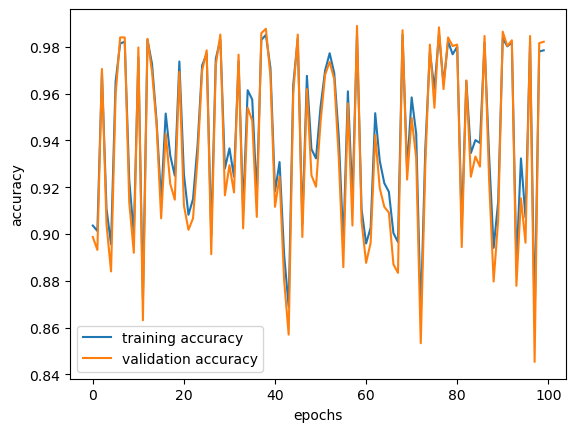

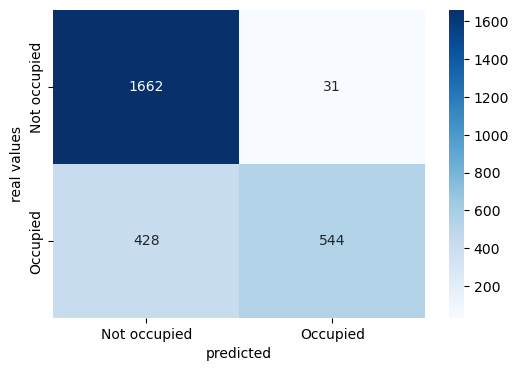

In [12]:
perceptron_model()

Using the default alpha and epochs values (0.1 and 100 respectively), we can see that the training and validation accuracies are all over the place. Like said previously, we will have to fine tune the values of each to get a better accuracy.

Accuracy: 0.8288930581613508


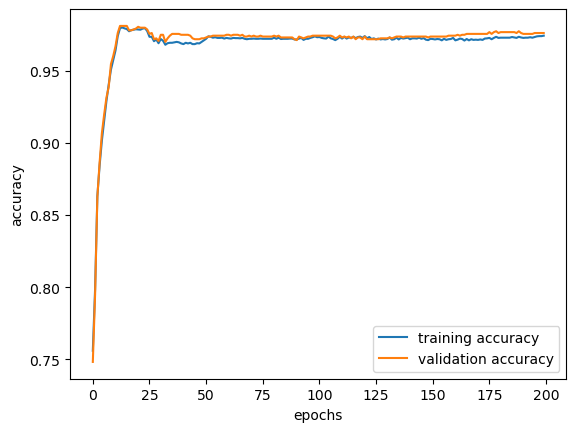

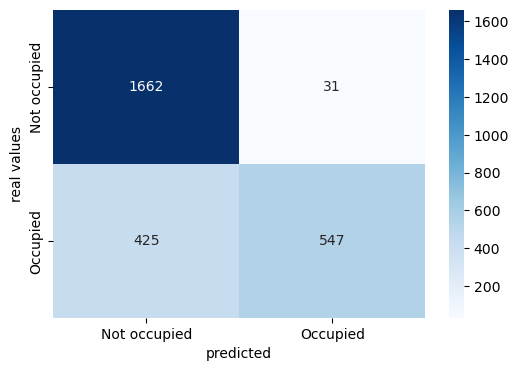

In [13]:
perceptron_model(alpha=0.0001, epochs=200)

After trying a few different values, this was the best accuracy I found. While the training and validation accuracies aren't all over the place anymore, there was still a significant amount of occupied rooms being classified as not occupied. This is probably due to the targets that aren't affected by the data.

# The Gaussian Naive Bayes' Approach

We will use this function to plot a confusion matrix later.  
**This isn't my code. It is slightly edited to work with my usecase, but this was originally written by the instructors of ITCS-3156 at the University of North Carolina at Charlotte.**

In [14]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None,
    xlabel: str = '',
    ylabel: str = ''
) -> pd.DataFrame:
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='d')
    plt.xlabel("predicted")
    plt.ylabel("real values")
    plt.show()
    return cfm_df

Yet again, we still need to preprocess the data. However, we have to do less this time:
- Drop the features if we want to drop features
- Create a validation set

In [15]:
def get_preprocessed_data_naive_bayes(drop_features: List[str] = None) -> Tuple[np.ndarray]:
    # copy the training sets
    X_trn = room_trn.data.copy()
    y_trn = room_trn.target.copy()

    # copy the testing sets
    X_tst = room_tst.data.copy()
    y_tst = room_tst.target.copy()

    # drop features from the data if its inputted
    if drop_features is not None:
        X_trn = X_trn.drop(columns=drop_features)
        X_tst = X_tst.drop(columns=drop_features)

    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=0.8, random_state=42)

    # converting the labels to arrays since some of them might be panda series
    y_trn = np.array(y_trn)
    y_vld = np.array(y_vld)
    y_tst = np.array(y_tst)
    
    # reshape targets to be 2D column vectors
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

For gaussian naive bayes', a few formulas are required for it to work. They are implemented here (the exact formulas are listed in the comments of each functions): 

In [16]:
def compute_log_priors(y: np.ndarray) -> np.ndarray:
    _, count = np.unique(y, return_counts=True)

    # P(y) = log((num samples of label) / (num samples))
    return np.log(count / len(y))

def log_gaussian(
    x: np.ndarray, 
    mu: Union[np.ndarray, float], 
    sigma: Union[np.ndarray, float],
) -> np.ndarray:
    
    part1 = np.log(sigma ** 2 * 2 * np.pi)
    part2 = ((x - mu) / sigma) ** 2

    # P(X | y) = -0.5 * (log(2 * sigma^2 * pi) + ((X - mu) / sigma)^2)
    return -0.5 * (part1 + part2)

def compute_log_likelihoods(X, means, stds, verbose=True):
    log_likelihoods = []
    
    # loop over every mean and standard deviation
    for i in range(means.shape[0]):
        # current mean and std
        mu = means[i]
        sigma = stds[i]

        # calculate the feature log likelihood using the log gaussian
        feature_log_likelihoods = log_gaussian(X, mu, sigma)

        # calculate the class log likelihood by summing over the feature
        # log likelihoods
        class_log_likelihoods = np.sum(feature_log_likelihoods, axis=1)

        # add the class log likelihood to the list
        log_likelihoods.append(class_log_likelihoods)

    # return the log likelihood for each feature
    return np.array(log_likelihoods).T

Those formulas require parameters mu and sigma, which are mean and standard deviation respectively. This function calculates them using the dataset's data.

In [17]:
def compute_parameters(
    X: np.ndarray, 
    y: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    # create lists for the means and stds
    means = []
    stds = []

    # count of unique class labels
    K = np.unique(y)

    # flatten the labels for future steps
    y = y.flatten()
    
    # loop over every class label
    for k in K:
        # current feature
        X_k = X[y == k]

        # calculate the mean and std
        mu = np.mean(X_k, axis=0)
        sigma = np.std(X_k, axis=0)

        # add the mean and std to the list/array to be returned
        means.append(mu)
        stds.append(sigma)
    
    return np.array(means), np.array(stds)

Here we implement the algorithm. This time, it does not rely on alpha and epoch values, so the prediction will be much easier to set up.

In [18]:
class GaussianNaiveBayes():
    def __init__(self):
        self.log_priors = None
        self.means = None
        self.stds = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        self.log_priors = compute_log_priors(y)
        self.means, self.stds = compute_parameters(X, y)
        
        return self
        
    def predict(self, X: np.ndarray):
        a = compute_log_likelihoods(X, self.means, self.stds) + self.log_priors

        # prediction = argmax(log(P(X = X | Y = y) + log(P(Y = y)))
        return np.argmax(a, axis=1)

Here we can test our completed model.

In [19]:
def gaussian_naive_bayes_model(
    drop_features: List[str] = None,
):
    # the only class names that we can have is not occupied or occupied
    class_names = {
        0: 'Not occupied',
        1: 'Occupied'
    }

    # get the preprocessed sets
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data_naive_bayes(drop_features=drop_features)

    # fit the algorithm
    gnb = GaussianNaiveBayes()
    gnb.fit(X_trn, y_trn)

    # predict with the training set
    trn_predictions = gnb.predict(X_trn).flatten()
    y_trn = y_trn.flatten()
    print(f'Training Accuracy: {accuracy(y_trn, trn_predictions)}')

    # predict with the validation set
    vld_predictions = gnb.predict(X_vld).flatten()
    y_vld = y_vld.flatten()
    print(f'Validation Accuracy: {accuracy(y_vld, vld_predictions)}')

    # predict with the testing set
    tst_predictions = gnb.predict(X_tst).flatten()
    y_tst = y_tst.flatten()
    print(f'Testing Accuracy: {accuracy(y_tst, tst_predictions)}')

    # plot the confusion matrix of each prediction set
    plot_confusion_matrix(y_trn, trn_predictions, class_names, xlabel='predicted', ylabel='real value')
    plot_confusion_matrix(y_vld, vld_predictions, class_names, xlabel='predicted', ylabel='real value')
    plot_confusion_matrix(y_tst, tst_predictions, class_names, xlabel='predicted', ylabel='real value')

Training Accuracy: 0.9780472827755603
Validation Accuracy: 0.9797421731123389
Testing Accuracy: 0.9774859287054409


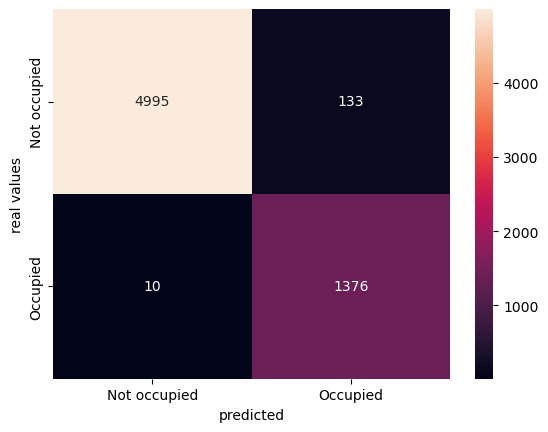

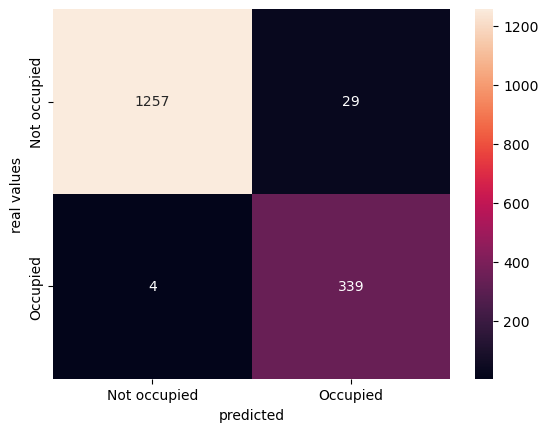

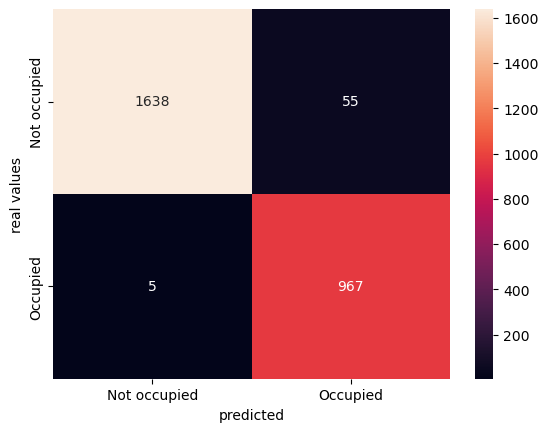

In [20]:
gaussian_naive_bayes_model()

It seems as if dropping features was not necessary to get a reliable prediction, as every prediction is above 97.7% accurate.  
However, we may be able to drop some features to increase that accuracy. If you look at the map of the features, Light and CO2 seem to very good indicators of if a room is occupied or not, so lets drop the other features to see if we can get better predictions.

Training Accuracy: 0.9835738409579368
Validation Accuracy: 0.9840392879066913
Testing Accuracy: 0.9771106941838649


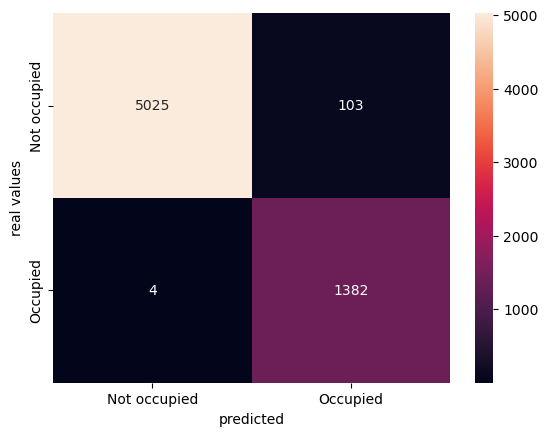

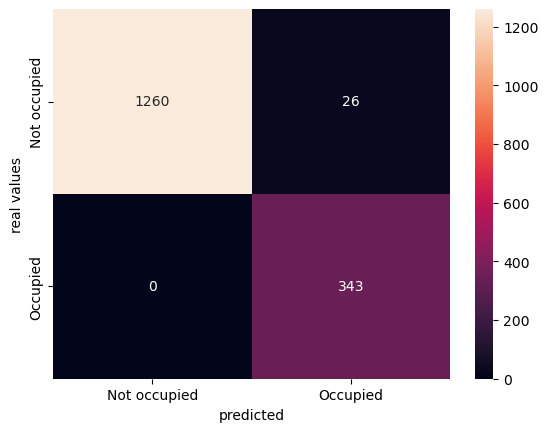

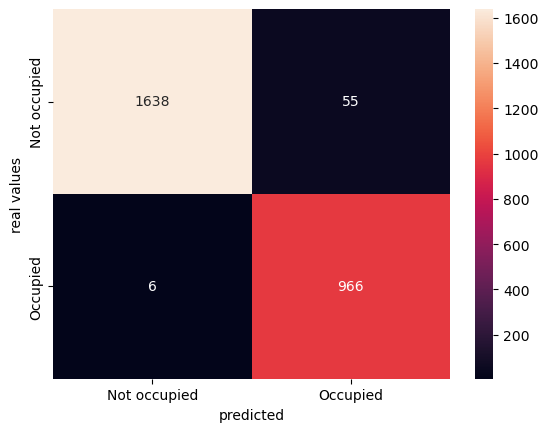

In [21]:
test_drop_features = ['Humidity', 'Temperature', 'HumidityRatio']

gaussian_naive_bayes_model(drop_features=test_drop_features)

It seems as if dropping those features made a difference, however, it is a very slight difference. For the testing and validation sets, it only improved accuracy by 0.5%. For the testing set, it actually dropped the accuracy slightly by 0.03%.  

Even so, the accuracy of the gaussian naive bayes' model completely outperformed the perceptron model in this scenario.